In [24]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [10]:
initialize()

In [1]:
from utilsk import decide_next_cell_to_explore,find_borderline_cells, initialize,perform_action,coordinates_to_actions,astar,obschar_to_mask, actions, positions,  process_state, show_match
from pyswip import Prolog
import matplotlib.pyplot as plt
import numpy as np
import time


In [12]:
ENV='MiniHack-KeyRoom-S15-v0'
# ENV='MiniHack-CorridorBattle-v0'
H = 10
W = 10
NUM_EPISODES = 1
MAX_STEPS = 450
PATH = 'kbkey.pl'

KB = Prolog()
KB.consult(PATH)

In [13]:
import gym
import minihack
import matplotlib.pyplot as plt
from minihack import LevelGenerator
from nle import nethack

# maps = [
#     """
# --------------------------------------
# |....................................|
# |....................................|
# |....................................|
# |....................................|
# |....................................|
# |....................................|
# |....................................|
# ||||||||.|||||.......................|
# |............|.......................|
# |............|.......................|
# |............|.......................|
# |............|.......................|
# |............|.......................|
# --------------------------------------
# """,
#     """
# --------------------------------------
# |....................................|
# |..-----....|..|.............|.......|
# |..|   |..--|--|-------...------.....|
# |..--- |....|..|.....................|
# |....| ||......||....-----......|....|
# |....|  |-------.........|......|....|
# |....|  |................|||..|||....|
# ------  |-------....------......|....|
#         |......|................|..|||
#         |......--------.........|....|
#         |.............|---------|....|
#         |..............#########.....|
#         |.............|---------|....|
#         ------------------------------ 
# """,
#     """
# --------------------------------------
# |............#########.......|.......|
# |..-----....|..|-------......|.......|
# |..|   |----|--|..........------.....|
# |..---      |..|.....................|
# |....|      |..||....-----......|....|
# |....|--|-------.....|...|......|....|
# |........................|||..|||....|
# --------|-------....------......|....|
#         |......|.........|......|..|||
#         |......-----------......|....|
#         |.............|---------|....|
#         |..............#########.....|
#         |.............|---------|....|
#         ------------------------------ 
# """
# ,
# """
# --------------------------------------
# |.....|......................|.......|
# |..-----....|..|-------......|.......|
# |..|   |----|..|..........------.....|
# |..---      |..|.....................|
# |....|      |..||....-----......|....|
# |....|--|-------.....|...|......|....|
# |........................|||..|||....|
# --------|-------....------......|....|
#         |......|.........|......|..|||
#         |......-----------......|....|
#         |.............|---------|...||
#         |..............#########.....|
#         |.............|---------|....|
#         ------------------------------ 
# """,
# """
# --------------------------------------
# |............#########.......|.......|
# |..-----....|..|-------............|||
# |..|   |----|--|.....|....------.....|
# |..---      |..|.....|....|..........|
# |....|      ...||....-----......|....|
# |....|----------.....|...|......|....|
# |.....#########..........|||..|||....|
# --------|-------....------......|....|
#         |......|................|..|||
#         |......-----------......|....|
#         |.............|---------|....|
#         |..............#########.....|
#         |.............|---------|....|
#         ------------------------------ 
# """,
# """
#                        ---------------
#                        |.....|.......|
#    -----       |-------............|||
# |--|   |----|--|..........------.....|
# |..---      |..|..........|..........|
# |....|      |..||....-----......|....|
# |....|--------.-.....|   |......|....|
# |....................|   |||..|||....|
# --------|-----------------......|....|
#         |......|................|..|||
#         |......-----------......|....|
#         |.............|---------|....|
#         |..............#########.....|
#         |.............|---------|....|
#         ------------------------------ 
# """
# ]

# lvl_gen = LevelGenerator(map=map, lit=True)
# lvl_gen.set_start_pos((3, 6))
# lvl_gen.add_door("closed", place=(8,8))
# lvl_gen.add_object(name='skeleton key', symbol='(', place=(28,7))
# lvl_gen.add_goal_pos((11, 10))

map=[
"""
-----       -------------------
|...|       |.................|
|....#######..................|
|...|       |.................|
-----       ----|.....|-------|
       ---------|.....|-------|
       |......................|
|------|...|...|..............|
|..........|...|..............|
|..........|...|..............|
|----------|...|--|...........|
|.................|...........|
|.................|...........|
|------------.....|...........|
|...........|.................|
|...........|.................|
|...........|.................|
|...........|.................|
|.............................|
|...........|.................|
-------------------------------
"""]

lvl_gen = LevelGenerator(map=map[0], lit=False)
lvl_gen.set_start_pos((1, 1))
# lvl_gen.add_monster(name="giant rat", place=(27, 1))
# lvl_gen.add_monster(name="giant rat", place=(26, 1))
# lvl_gen.add_monster(name="giant rat", place=(27, 2))
# lvl_gen.add_monster(name="giant rat", place=(26, 2))
# lvl_gen.add_monster(name="giant rat", place=(27, 3))
# lvl_gen.add_monster(name="giant rat", place=(26, 3))
lvl_gen.add_door("closed", place=(12,18))
lvl_gen.add_object(name='skeleton key', symbol='(', place=(3,8))
lvl_gen.add_goal_pos((4, 17)) #TODO: change



  

# maps = ["""
# --------------------------------------
# |....................................|
# |..-----....|..|.............|.......|
# |..|   |..--|--|-------...------.....|
# |..--- |....|..|.....................|
# |....| ||......||....-----......|....|
# |....|  |-------.........|......|....|
# |....|  |................|||..|||....|
# ------  |-------....------......|....|
#         |......|................|..|||
#         |......--------.........|....|
#         |.............|---------|....|
#         |..............#########.....|
#         |.............|---------|....|
#         ------------------------------ 
# """]

# lvl_gen = LevelGenerator(map=maps[0], lit=False)
# lvl_gen.set_start_pos((3, 6))
# # lvl_gen.add_monster(name="giant rat", place=(10, 11))
# # lvl_gen.add_monster(name="giant rat", place=(10, 12))
# # lvl_gen.add_monster(name="giant rat", place=(10, 13))
# # lvl_gen.add_monster(name="giant rat", place=(11, 11))
# # lvl_gen.add_monster(name="giant rat", place=(11, 12))
# # lvl_gen.add_monster(name="giant rat", place=(11, 13))
# lvl_gen.add_door("closed", place=(32,12))
# lvl_gen.add_object(name='skeleton key', symbol='(', place=(28,7))
# lvl_gen.add_goal_pos((11, 10))

initialize()

MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.OPEN
)

env = gym.make("MiniHack-Skill-Custom-v0",
               character="rog-hum-cha-mal",
               observation_keys=('screen_descriptions','chars','glyphs','inv_strs','blstats','message','pixel','pixel_crop'),
               des_file = lvl_gen.get_des(),
               max_episode_steps=600,
               actions = NAVIGATE_ACTIONS)
obs=env.reset() # each reset generates a new environment instance
env.render()





Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                        ---                                                     
                        |@.                                                     
                        |..                                                     
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           

In [29]:
rewards = []
performed_acts=[]

def run(obs,performed_acts,KB,env):
    initialize()

    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    # obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False
    info=None

    # Main loop
    plan=[]
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB)

        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
       
        action = list(KB.query('action(X)'))[0]["X"]
      
        # print(f'>> Current action from Prolog: {action}')
        
        if action:
            navs=[]
            if 'go(stairs)' in action:
                agent_p=positions['agent']
                stairs_p=positions['stairs']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, stairs_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

            elif 'enter(door)' in action:
                agent_p=positions['agent']
                door_p=positions['door']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                KB.retractall('standing_next(door)')

                
            elif 'opendoor' in action:
                obs, reward, done, info = perform_action("opendoor", env, KB,obs)
                performed_acts+=["opendoor"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            elif "pick" in action:
                obs, reward, done, info = perform_action("pick", env, KB,obs)
                performed_acts+=["pick"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            if "go(door)" in action:
                agent_p=positions['agent']
                door_p=positions['door_front']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            elif "go(key)" in action:
                agent_p=positions['agent']
                key_p=positions['key']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, key_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'explore' in action:
                b_cell=decide_next_cell_to_explore(obs)
                agent_p=positions['agent']
                masked=obschar_to_mask(obs)
                # print(agent_p,b_cell)
                path = astar(masked,agent_p, b_cell)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            for nav in navs:
                performed_acts+=[nav]

                process_state(obs, KB)

                if list(KB.query('action(X)'))[0]["X"] != action:
                    break
                    
                obs, reward, done, info = perform_action(nav, env, KB,obs)
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                # env.render()
                
                

        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break


    # Display game with interface
    show_match(ep_states,0,600,250,1350)
    # show_match(ep_states,0,200,0,200)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    # rewards.append(reward)

    # # reset the environment and retract axioms that may cause errors
    # obs = env.reset()
    # KB.retractall('stepping_on(agent,_,_)')
    


Episode 0 - 394 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
After 1 episodes, mean return is 0.0
The rewards of the episodes are: []


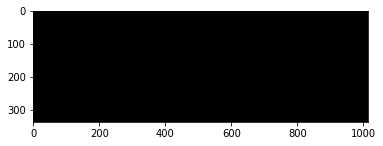

In [30]:
for episode in range(NUM_EPISODES):
    run(obs,performed_acts,KB,env)
    


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)

In [6]:
env.render()


                                                                                
                        -----                                                   
                        |<..|                                                   
                        |....#                                                  
                        |@..|                                                   
                        -----                                                   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           

In [15]:
process_state(obs, KB)
action = list(KB.query('standing_next(door)'))
action

[]

In [8]:
action = list(KB.query('action(X)'))[0]["X"]
action

'explore'

In [11]:
positions

{'agent': None, 'key': None, 'door': None, 'door_front': None, 'stairs': None}

In [37]:
b_cell=decide_next_cell_to_explore(obs)
agent_p=positions['agent']
masked=obschar_to_mask(obs)
# print(agent_p,b_cell)
path = astar(masked,agent_p, b_cell)
path.append(agent_p)
path.reverse()
navs = coordinates_to_actions(path)

In [12]:
borderline_cells = find_borderline_cells(obs)

In [13]:
borderline_cells

[]

In [38]:
b_cell

(2, 27)

In [29]:
navs

['east']

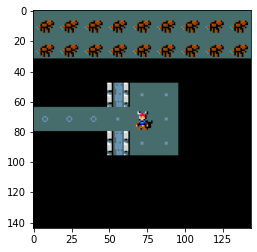

In [28]:
obs, reward, done, info=perform_action("east", env, KB,obs)
plt.imshow(obs['pixel_crop'])

In [16]:
 bytes(obs['message']).decode('utf-8').rstrip('\x00')

"You can't move diagonally into an intact doorway."

In [5]:
for obj in obs['inv_strs']:
        obj = bytes(obj).decode('utf-8').rstrip('\x00')
        print(obj)

a +0 short sword (weapon in hand)
9 +0 daggers (alternate weapon; not wielded)
an uncursed +1 leather armor (being worn)
an uncursed potion of sickness
an uncursed lock pick
an empty uncursed sack



















































In [11]:

bytes(obs['inv_strs'][15][50]).decode('utf-8').rstrip('\x00')

''

In [14]:
positions["door"], positions["agent"]

((11, 28), (10, 28))

In [ ]:
for i in range(21):
        for j in range(79):
            if not (obs['screen_descriptions'][i][j] == 0).all():
                obj = bytes(obs['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00')
                print(obj,obs["chars"][i][j],obs['glyphs'][i][j])

In [ ]:
obj = bytes(obs['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00')